<a id='top'></a>
<center><img src="../images/iteso_logo.png" style="width:180px;height:180px; vertical- align:middle;" align="middle"></center>
  
<h1><center><b>INSTITUTO TECNOLÓGICO Y DE ESTUDIOS SUPERIORES DE OCCIDENTE</b></center></h1>

<h2><center><b>Maestría en Ciencia de Datos <br><br>
    <br> Minería de Textos</b><br>
    <br> Proyecto Final: Speech Processing and Analysis</b></center></h2>
    
<h3><center><b>
               Ing. Adrián Ramos Pérez</b></center></h3>

Tabla de Contenidos <a id='contents'></a>
---
  [1. Carga de Audio desde Bucket de S3](#audio_read)
  [2. Transcripción de Audio a Texto.](#)
- [3. Tokenización y remover Stop Words.](#)
- [3. Sentiment Scoring.](#)
    - [3. Tokenización y remover Stop Words.](#)
- [3. Lematizar palabras para reducir la complejidad del corpus.](#)
- [4. ](#)

In [1]:
# Para obtener más de una salida por cada output de celda de Jupyter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# %conda update numpy

In [3]:
import numpy as np
import pandas as pd

import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize
from gensim import corpora, models, similarities
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

import soundfile as sf
import speech_recognition as spr
import librosa as lb
import librosa.display
from IPython.display import Audio

import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns

In [4]:
# %pip install -U numba

## . Importar bucket de S3: <a id='audio_read'></a>

In [5]:
# Se importa el SDK de AWS para Python, para poder hacer uso de S3 y otros servicios de AWS:
import boto3 as b3
import io
from io import BytesIO

# Se define el nombre del bucket utilizando la convención de PEP-8 para constantes:
AWS_REGION = "us-east-1"
S3_BUCKET_NAME = 'final-deployment'
AUDIO_FILES = 'audio_files/train/'

# Se crea instancia del servicio S3 para trabajar con buckets para guardar y leer artefactos derivados de los procesos que hagamos
s3_resource = b3.resource(service_name='s3', region_name=AWS_REGION) 
s3_client = b3.client(service_name='s3')

# Listar todos los objectos en el bucket
objects = s3_resource.Bucket(S3_BUCKET_NAME).objects.all()
for object in objects:
    print(object.key)

audio_files/
audio_files/ir_golpe16kHz.wav
audio_files/speech.wav
audio_files/train/
audio_files/train/AaronHuey_2010X.sph
audio_files/train/AimeeMullins_2009P.sph
audio_files/train/AlGore_2006.sph
audio_files/train/AlGore_2008.sph
audio_files/train/AndersYnnerman_2010X.sph
audio_files/train/AnupamMishra_2009I.sph
audio_files/train/BillClinton_2007.sph
audio_files/train/BillGates_2010.sph
audio_files/train/BillyGraham_1998.sph
audio_files/train/Bono_2005.sph
audio_files/train/DanBarber_2010.sph
audio_files/train/DanielKahneman_2010.sph
audio_files/train/EricMead_2009P.sph
audio_files/train/GaryFlake_2010.sph
audio_files/train/JamesCameron_2010.sph
audio_files/train/JaneMcGonigal_2010.sph
audio_files/train/JeffBezos_2003.sph
audio_files/train/JimFallon_2009.sph
audio_files/train/MichaelSpecter_2010.sph
audio_files/train/MichelleObama_2009P.sph
audio_files/train/RobertFull_2002.sph
audio_files/train/RobertGupta_2010U.sph
audio_files/train/TomWujec_2010U.sph
output/


In [6]:
sampling_rate = 16000

In [7]:
# Lectura del objeto de audio desde S3:
audio_objects = s3_resource.Bucket(f'{S3_BUCKET_NAME}').objects.filter(Prefix=AUDIO_FILES)
audios_arr=[]
names_arr=[]
for i, object in enumerate(audio_objects):
    print(object)
    audios_arr.append(object.get()['Body'].read()) #s3_resource.Object(bucket_name=S3_BUCKET_NAME, key=f'{object}')
    names_arr.append(object.key[18:])
    # audio_object

s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AaronHuey_2010X.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AimeeMullins_2009P.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AlGore_2006.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AlGore_2008.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AndersYnnerman_2010X.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/AnupamMishra_2009I.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/BillClinton_2007.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/BillGates_2010.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/BillyGraham_1998.sph')
s3.ObjectSummary(bucket_name='final-deployment', key='audio_files/train/Bon

File name: AnupamMishra_2009I.sph
Sampling rate:  16000 Hz
Duration: 17.2447 minutes - 1034.6811875 seconds
No. of Samples: 16554899


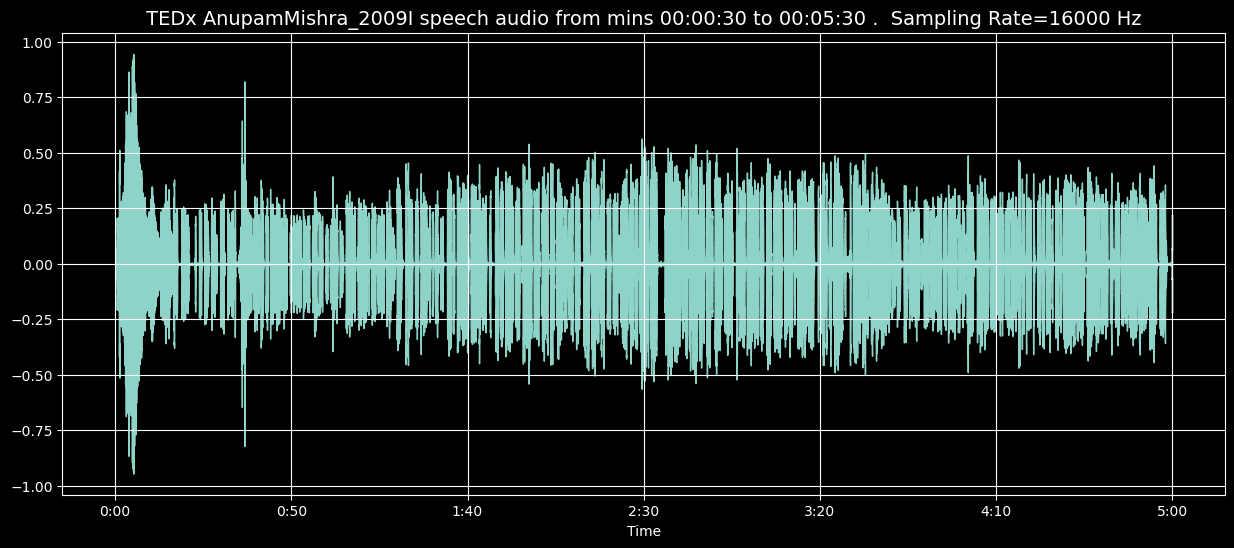

In [ ]:
from datetime import time
# for audio in audios_arr:
    
s3_audio_samples, sr = lb.load(io.BufferedReader(io.BytesIO(audios_arr[6])), sr=None, mono=True,offset=0.0,duration=None)

# Duración en segundos:
duration = len(s3_audio_samples)/sr
print(f'File name: {names_arr[6]}')
print(f'Sampling rate:  {str(sr)} Hz')
print(f'Duration: {duration/60:.4f} minutes - {str(duration)} seconds')
print(f'No. of Samples: {len(s3_audio_samples)}')

# Seccionar audio:
offset, sec = 30, 300
speech_pt1 = s3_audio_samples[offset*sr : (offset+sec)*sr]
speech_pt2 = s3_audio_samples[(offset+sec)*sr : (offset+2*sec)*sr]
speech_pt3 = s3_audio_samples[(offset+2*sec)*sr : (offset+3*sec)*sr]

# Reproducir el audio

# From 0:00:30 to 0:05:50
Audio(data=speech_pt1, rate=sr)
Audio(data=speech_pt2, rate=sr)
Audio(data=speech_pt3, rate=sr)

fig = plt.figure(figsize=(15,6))
to_mins = int((offset+sec)/60)
to_secs = int((offset+sec)%60)
name = f" TEDx {names_arr[6].removesuffix('.sph')} speech audio from mins {time(0,0,int(offset))} to { time(0, to_mins, to_secs) } ."
plt.title(f'{name}  Sampling Rate={sr} Hz ', fontsize=14)
plt.grid(True)
lb.display.waveshow(y=s3_audio_samples[:sec*sr],sr=sr)
plt.show()

# Conversión de Audio a Texto:

In [ ]:
import speech_recognition as spr

def audio2text(audio_data, sampling_rate):
    r = spr.Recognizer()
    # with open('audio.wav', 'r') as file:

    sf.write(file='audio.wav', data=audio_data, samplerate=sampling_rate)

    with spr.AudioFile('audio.wav') as source:
        audio = r.record(source) 
    
    return r.recognize_sphinx(audio)

speech_pt1_text = audio2text(speech_pt1, sampling_rate)
speech_pt2_text = audio2text(speech_pt2, sampling_rate)
speech_pt3_text = audio2text(speech_pt3, sampling_rate)

In [86]:
speech_pt3_text

"how bad for her body to the law is standing on a very iffy good advice to explain this is scott when the heavy mean he fell service for that and don't want to buy this does not go up and you can draw no water from a day that when these days nor when you read it to squeeze the moisture and heat in the beginning the same and they have done that is what that is the fire one part of a felony and tom did do someday turning busily and it was devoted to him by the engagement about some team the union fumble and the enemy had is so give some is to take in high risk his water this is the same guy who are more being no you don't find any when they are awesome wide but they were in the water goes down the route be given to draw water from who was effective for only at the c. n. they have received only six they needed six city we go through fraud and they didn't before you begin to find anyone who we're mean yorker in your feet deep in the bombay been rumors to these come to a yacht off six indee

# Tokenización y Stop Words removal:
***

In [ ]:
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

def preprocess(text):
    
    word_tokens = word_tokenize(text)
    sentence_tokens = sent_tokenize(text) # Para experimentación futura
      
    for _ in range(3):
        for token in word_tokens:
            if token in stopwords.words('english'):
                word_tokens.remove(token)
        print(f'Tokens: {len(word_tokens)} run:{_}')
    
    return word_tokens

speech_pt1_tokens = preprocess(speech_pt1_text)
speech_pt2_tokens = preprocess(speech_pt2_text)
speech_pt3_tokens = preprocess(speech_pt3_text)


speech_pt1_clean = TreebankWordDetokenizer().detokenize(speech_pt1_tokens)
speech_pt2_clean = TreebankWordDetokenizer().detokenize(speech_pt1_tokens)
speech_pt3_clean = TreebankWordDetokenizer().detokenize(speech_pt1_tokens)

speech_pt1_clean[:400]

Tokens: 449 run:0
Tokens: 356 run:1
Tokens: 328 run:2
Tokens: 464 run:0
Tokens: 357 run:1
Tokens: 327 run:2
Tokens: 461 run:0
Tokens: 341 run:1
Tokens: 308 run:2


"letting fake programs start anew bundy gordon indiann't dc disease inform country last thing busted nineteen days spent week expedientn't want lose three hundred feet deep give death watched peace mind topic thinking got thought comfort raise door duty visit suppose use technology sort bombs f. miller see soul big one golf said enlisted say yes find floppy different names golf denim one tool pader"

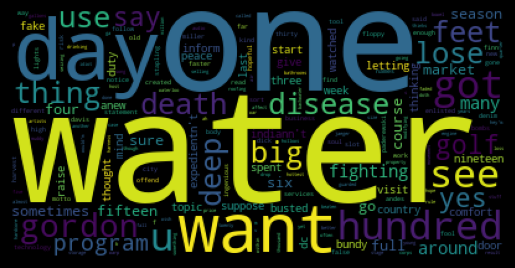

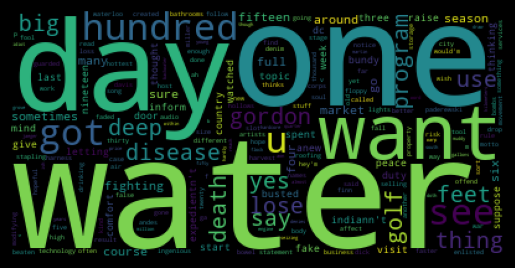

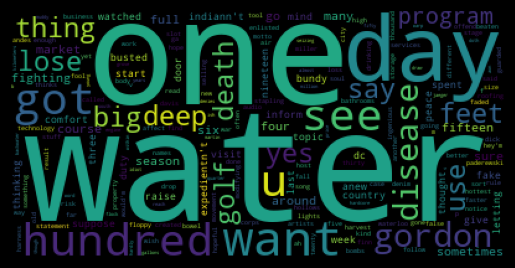

In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(text):
    
    wc = WordCloud().generate(text)
    plt.figure()
    plt.imshow(wc)
    plt.axis('off')
    plt.show()
    
    return None

plot_word_cloud(speech_pt1_clean)
plot_word_cloud(speech_pt2_clean)
plot_word_cloud(speech_pt3_clean)


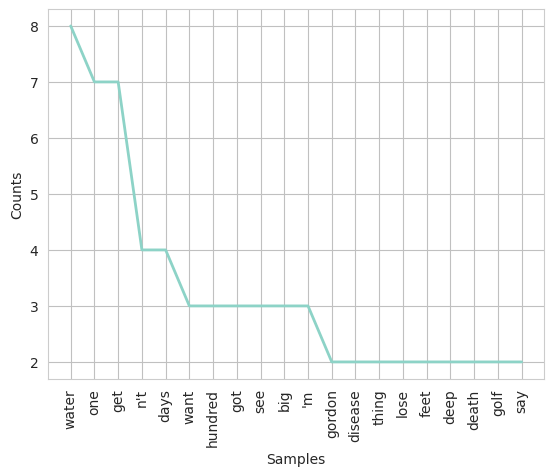

<Axes: xlabel='Samples', ylabel='Counts'>

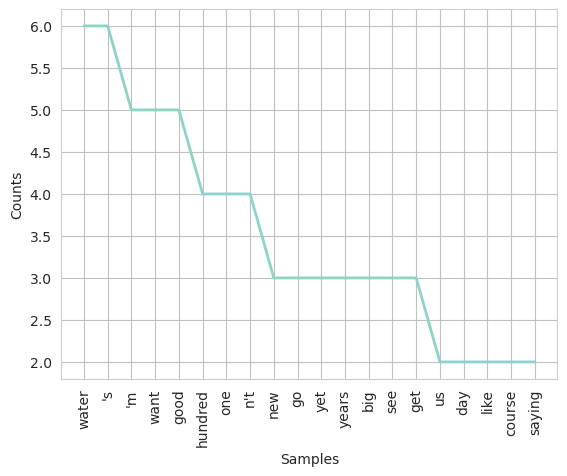

<Axes: xlabel='Samples', ylabel='Counts'>

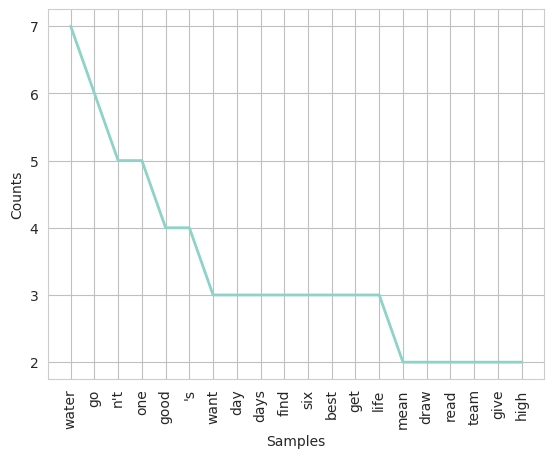

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
# fig = plt.subplots(3,1, figsize=(8,4))
with sns.axes_style('whitegrid'):
    freq = nltk.FreqDist(speech_pt1_tokens)
    freq.plot(20, cumulative=False)
    freq = nltk.FreqDist(speech_pt2_tokens)
    freq.plot(20, cumulative=False)
    freq = nltk.FreqDist(speech_pt3_tokens)
    freq.plot(20, cumulative=False)
    plt.show()

# Sentiment Scoring

In [ ]:
# %pip install afinn
from afinn import Afinn

def scoring(tokens_list):
    df = pd.DataFrame(tokens_list, columns=['token'])
    afinn_scorer = Afinn()

    df['score'] = df['token'].map(afinn_scorer.score).astype(int)
    scores_df = df[df['score']!=0]
    
    return scores_df

sp1_scores_df = scoring(speech_pt1_tokens)
sp2_scores_df = scoring(speech_pt2_tokens)
sp3_scores_df = scoring(speech_pt3_tokens)

sp1_scores_df

,token,score
1,fake,-3
10,disease,-1
22,want,1
29,death,-2
31,peace,2
37,comfort,2
51,big,1
57,yes,1
72,fighting,-2
74,fool,-2


In [ ]:
sp1_scores_freq = sp1_scores_df\
                .score\
                .value_counts()\
                .sort_index(ascending=True)\
                .to_frame('n')
sp2_scores_freq = sp2_scores_df\
                .score\
                .value_counts()\
                .sort_index(ascending=True)\
                .to_frame('n')
sp3_scores_freq = sp3_scores_df\
                .score\
                .value_counts()\
                .sort_index(ascending=True)\
                .to_frame('n')
sp1_scores_freq

,n
-4,1
-3,3
-2,11
-1,5
1,10
2,9
3,1


<Axes: >

Text(0.5, 0, 'Ponderación del Sentimiento')

Text(0, 0.5, 'Frecuencia de las Palabras')

Text(0.5, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '-4'),
  Text(1, 0, '-3'),
  Text(2, 0, '-2'),
  Text(3, 0, '-1'),
  Text(4, 0, '1'),
  Text(5, 0, '2'),
  Text(6, 0, '3')])

<Axes: >

Text(0.5, 0, 'Ponderación del Sentimiento')

Text(0, 0.5, 'Frecuencia de las Palabras')

Text(0.5, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '-3'),
  Text(1, 0, '-2'),
  Text(2, 0, '-1'),
  Text(3, 0, '1'),
  Text(4, 0, '2'),
  Text(5, 0, '3')])

<Axes: >

Text(0.5, 0, 'Ponderación del Sentimiento')

Text(0, 0.5, 'Frecuencia de las Palabras')

Text(0.5, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, '-4'),
  Text(1, 0, '-3'),
  Text(2, 0, '-2'),
  Text(3, 0, '-1'),
  Text(4, 0, '1'),
  Text(5, 0, '2'),
  Text(6, 0, '3'),
  Text(7, 0, '4')])

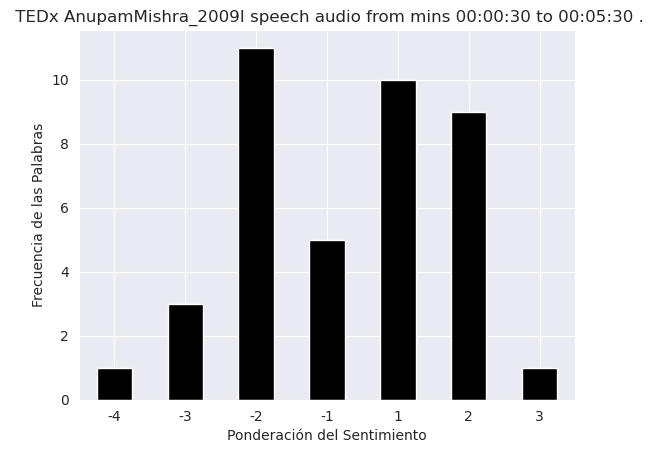

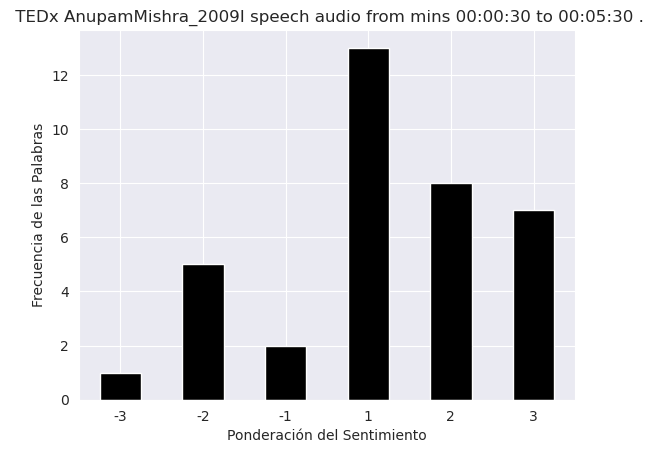

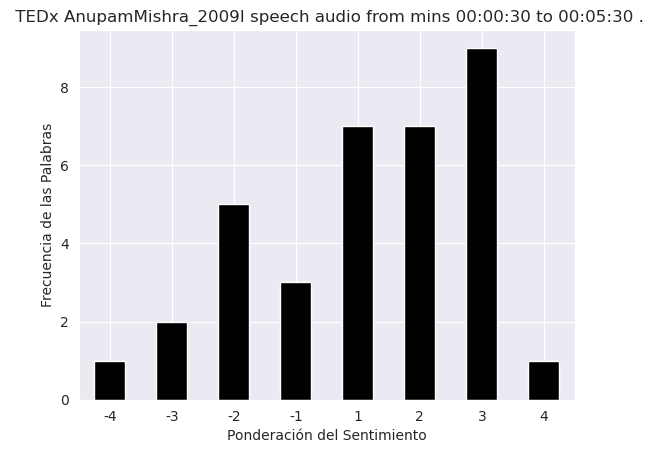

In [18]:
with sns.axes_style('darkgrid'):
    sp1_scores_freq.plot.bar(color='black', grid=True, legend=False)
    plt.xlabel('Ponderación del Sentimiento')
    plt.ylabel('Frecuencia de las Palabras')
    plt.title(name)
    plt.xticks(rotation=0)
    
    sp2_scores_freq.plot.bar(color='black', grid=True, legend=False)
    plt.xlabel('Ponderación del Sentimiento')
    plt.ylabel('Frecuencia de las Palabras')
    plt.title(name)
    plt.xticks(rotation=0)
    
    sp3_scores_freq.plot.bar(color='black', grid=True, legend=False)
    plt.xlabel('Ponderación del Sentimiento')
    plt.ylabel('Frecuencia de las Palabras')
    plt.title(name)
    plt.xticks(rotation=0)

# Tabla del Score del Sentimiento:


In [31]:
sp1_score_acc = sp1_scores_df.groupby(sp1_scores_df['score'] // 1)\
            .score.mean()\
            .to_frame('score')
sp2_score_acc = sp1_scores_df.groupby(sp2_scores_df['score'] // 1)\
            .score.mean()\
            .to_frame('score')
sp3_score_acc = sp1_scores_df.groupby(sp3_scores_df['score'] // 1)\
            .score.mean()\
            .to_frame('score')
print(f'{sp1_score_acc}\n\n{sp2_score_acc}\n\n{sp3_score_acc}')

       score
score       
-4      -4.0
-3      -3.0
-2      -2.0
-1      -1.0
 1       1.0
 2       2.0
 3       3.0

       score
score       
1.0     -2.0
2.0     -2.0
3.0     -2.0

       score
score       
-1.0    -2.0
 1.0     1.0
 2.0     0.0
 3.0    -1.0


<Axes: xlabel='score'>

Text(0.5, 0, 'Sección de líneas')

Text(0, 0.5, 'Promedio del Score del Sentimiento')

Text(0.0, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]),
 [Text(-5.0, 0, '−5'),
  Text(-4.0, 0, '−4'),
  Text(-3.0, 0, '−3'),
  Text(-2.0, 0, '−2'),
  Text(-1.0, 0, '−1'),
  Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '3'),
  Text(4.0, 0, '4')])

<Axes: xlabel='score'>

Text(0.5, 0, 'Sección de líneas')

Text(0, 0.5, 'Promedio del Score del Sentimiento')

Text(0.0, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75, 3.  , 3.25]),
 [Text(0.75, 0, '0.75'),
  Text(1.0, 0, '1.00'),
  Text(1.25, 0, '1.25'),
  Text(1.5, 0, '1.50'),
  Text(1.75, 0, '1.75'),
  Text(2.0, 0, '2.00'),
  Text(2.25, 0, '2.25'),
  Text(2.5, 0, '2.50'),
  Text(2.75, 0, '2.75'),
  Text(3.0, 0, '3.00'),
  Text(3.25, 0, '3.25')])

<Axes: xlabel='score'>

Text(0.5, 0, 'Sección de líneas')

Text(0, 0.5, 'Promedio del Score del Sentimiento')

Text(0.0, 1.0, ' TEDx AnupamMishra_2009I speech audio from mins 00:00:30 to 00:05:30 .')

(array([-1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5]),
 [Text(-1.5, 0, '−1.5'),
  Text(-1.0, 0, '−1.0'),
  Text(-0.5, 0, '−0.5'),
  Text(0.0, 0, '0.0'),
  Text(0.5, 0, '0.5'),
  Text(1.0, 0, '1.0'),
  Text(1.5, 0, '1.5'),
  Text(2.0, 0, '2.0'),
  Text(2.5, 0, '2.5'),
  Text(3.0, 0, '3.0'),
  Text(3.5, 0, '3.5')])

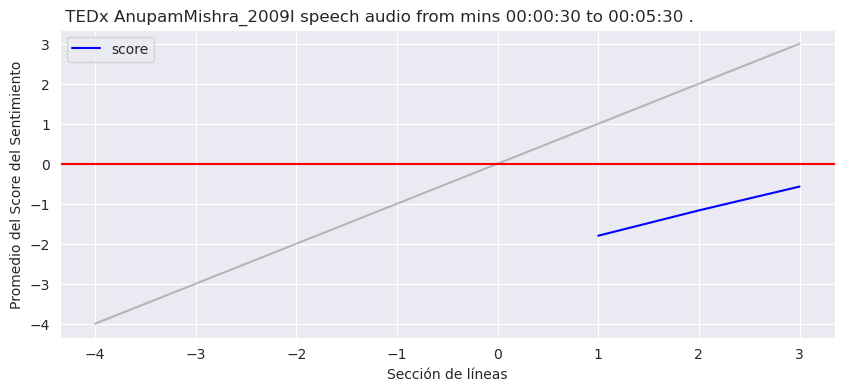

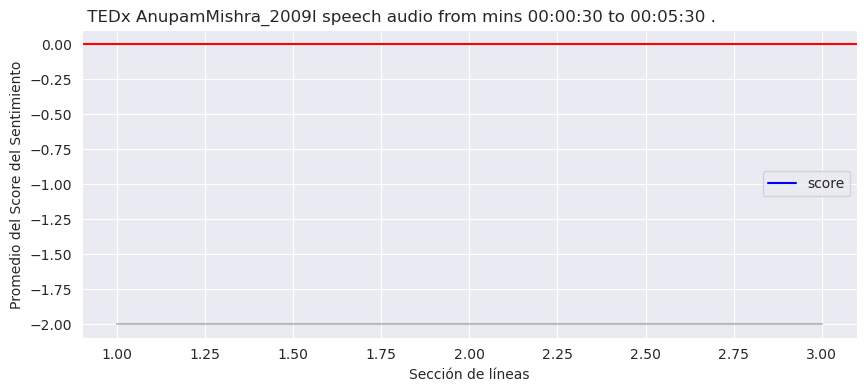

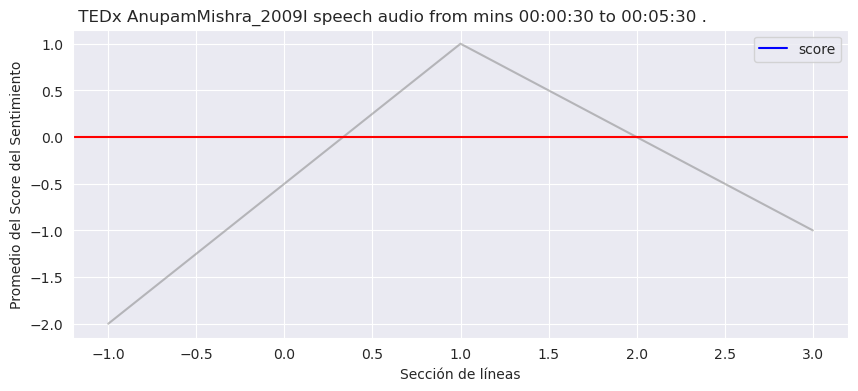

In [44]:
with sns.axes_style('darkgrid'):
    ax = sp1_score_acc.plot.line(legend=False, figsize=(10,4), grid=True, alpha=0.5, color='gray')
    sp1_score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='blue')
    plt.xlabel('Sección de líneas')
    plt.ylabel('Promedio del Score del Sentimiento')
    plt.title(name, loc='left')
    plt.axhline(0, color='red')
    plt.xticks(rotation=0)
    
    ax = sp2_score_acc.plot.line(legend=False, figsize=(10,4), grid=True, alpha=0.5, color='gray')
    sp2_score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='blue')
    plt.xlabel('Sección de líneas')
    plt.ylabel('Promedio del Score del Sentimiento')
    plt.title(name, loc='left')
    plt.axhline(0, color='red')
    plt.xticks(rotation=0)
    
    ax = sp3_score_acc.plot.line(legend=False, figsize=(10,4), grid=True, alpha=0.5, color='gray')
    sp3_score_acc.rolling(10, min_periods=5).mean().plot.line(ax=ax, color='blue')
    plt.xlabel('Sección de líneas')
    plt.ylabel('Promedio del Score del Sentimiento')
    plt.title(name, loc='left')
    plt.axhline(0, color='red')
    plt.xticks(rotation=0)

## Bag of Words
***

In [45]:
speeches = [speech_pt1_clean, speech_pt2_clean, speech_pt3_clean]
speeches[2]

"letting fake programs start anew bundy gordon indiann't dc disease inform country last thing busted nineteen days spent week expedientn't want lose three hundred feet deep give death watched peace mind topic thinking got thought comfort raise door duty visit suppose use technology sort bombs f. miller see soul big one golf said enlisted say yes find floppy different names golf denim one tool paderewski new work program far business fighting old fool around city harvest thirty many services faster lights u. high risk slot way gone got notice created kind false statement day offend lose andes body read motto want follow stapling davis sometimes ingenious enough dick's get hopeful finn bathrooms u. ga property waterloo full go v. audio roofing affect better would'm going artists drop sure result case hundred called death one season drinking water stuff hottest selling market four p. m. around host often uses guarded loss yet wish get done things hey'm beaten get hollows war storage think

In [46]:
texts = [[word for word in speech.split()] for speech in speeches]
texts[1][:10]

['letting',
 'fake',
 'programs',
 'start',
 'anew',
 'bundy',
 'gordon',
 "indiann't",
 'dc',
 'disease']

In [47]:
from gensim import corpora
from gensim.corpora.dictionary import Dictionary

# Crear bolsa de palabras a partir de lista de documentos
# Se crea diccionario:
dictionary = corpora.Dictionary(texts)
corpus_bow = [dictionary.doc2bow(text) for text in texts]
corpus_bow[0][:9]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [49]:
from gensim.models import TfidfModel

tfidf = TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]
# corpus_tfidf[0][:]

# Modelado de Tópicos con LDA
***
La alocación latete de Dirichlet permite modelar por tópicos 
Los pasos para el modelado de tópicos son:

1. Preprocesamiento de los datos: Limpiar, remover stopwords y lematizar.
2. Identificar los tópicos: de manera no supervisada (LDA) . 
3. Evaluar la calidad del modelo 

In [50]:
n_docs = 3
n_topics = 3
n_words = len(corpus_bow[0])
n_words

260

## LDA con Bag of Words

In [51]:
from gensim.models.ldamodel import LdaModel

lda_bow = LdaModel(corpus_bow, num_topics=n_topics, id2word=dictionary, random_state=0)
lda_bow_topics = lda_bow.print_topics()

for topic in lda_bow_topics:
    print(topic)

(0, '0.017*"get" + 0.017*"water" + 0.014*"one" + 0.010*"days" + 0.008*"want" + 0.008*"hundred" + 0.007*"four" + 0.007*"see" + 0.007*"disease" + 0.007*"fighting"')
(1, '0.019*"one" + 0.017*"get" + 0.015*"water" + 0.012*"days" + 0.010*"want" + 0.010*"hundred" + 0.009*"got" + 0.007*"see" + 0.007*"golf" + 0.007*"deep"')
(2, '0.026*"water" + 0.020*"one" + 0.019*"get" + 0.010*"days" + 0.010*"see" + 0.009*"got" + 0.007*"hundred" + 0.007*"want" + 0.007*"death" + 0.007*"many"')


## LDA con Tfidf:

In [52]:
lda_tfidf = LdaModel(corpus = corpus_tfidf, num_topics=n_topics, id2word=dictionary)
lda_tfidf_topics = lda_tfidf.print_topics()

for topic in lda_tfidf_topics:
    print(topic)

(0, '0.004*"program" + 0.004*"producers" + 0.004*"purity" + 0.004*"pumping" + 0.004*"property" + 0.004*"project" + 0.004*"programs" + 0.004*"question" + 0.004*"pot" + 0.004*"pilgrimage"')
(1, '0.004*"program" + 0.004*"producers" + 0.004*"purity" + 0.004*"pumping" + 0.004*"property" + 0.004*"project" + 0.004*"programs" + 0.004*"question" + 0.004*"pot" + 0.004*"pilgrimage"')
(2, '0.004*"program" + 0.004*"producers" + 0.004*"purity" + 0.004*"pumping" + 0.004*"property" + 0.004*"project" + 0.004*"programs" + 0.004*"question" + 0.004*"pot" + 0.004*"pilgrimage"')


/home/studio-lab-user/.conda/envs/thesis_env/lib/python3.9/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


In [62]:
# def plot_top_words(model, feature_names, n_top_words, title):
#     # Malla para graficar 2 filas 5 columnas
#     fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
#     axes = axes.flatten()
#     # model.components_ hace referencia a la matriz phi
#     for topic_idx, topic in enumerate(model.components_):
#         # La hacemos distribución
#         topic /= topic.sum()
#         # Seleccionamos los índices más relevantes del tópico
#         top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
#         # Obtenemos las palabras
#         top_features = [feature_names[i] for i in top_features_ind]
#         # Obtenemos la ponderación
#         weights = topic[top_features_ind]
        
#         # Graficamos barras horizontales por tópicos con las palabras más relevantes
#         ax = axes[topic_idx]
#         ax.barh(top_features, weights, height=0.7)
#         ax.set_title(f'Topic {topic_idx +1}',
#                      fontdict={'fontsize': 30})
#         ax.invert_yaxis()
#         ax.tick_params(axis='both', which='major', labelsize=20)
#         for i in 'top right left'.split():
#             ax.spines[i].set_visible(False)
#         fig.suptitle(title, fontsize=40)

#     plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
#     plt.show()

In [55]:
# from sklearn.feature_extraction.text import CountVectorizer

# # Vectorizamos el texto por medio de cuentas crudas de palabras
# vectorizer = CountVectorizer(max_df=0.95, min_df=2,
#                              max_features=n_words,
#                              stop_words='english')

# corpus = vectorizer.fit_transform(corpus_bow[:n_docs])

In [57]:
# plot_top_words(lda_bow, vectorizer.get_feature_names(), 10, 'Topics in LDA model')

In [ ]:
# Observación por Speech
x = {'text': '',
     'word_count': 0,
     'top_word_1': '',
     'top_word_2': '',
     'top_word_3': '',
     'class': '',
     'sentiment': ''
}
x

In [ ]:
# %pip install spacy-annotator
# import spacy_annotator as spa

In [60]:
# from sklearn.decomposition import LatentDirichletAllocation

# lda = LatentDirichletAllocation(n_components=10)
# lda.fit(corpus_bow)

In [61]:
# Vectorizamos el texto por medio de cuentas crudas de palabras
# vectorizer = CountVectorizer(max_df=0.95, min_df=2,
#                              max_features=n_words,
#                              stop_words='english')
# corpus = vectorizer.fit_transform(data[:n_docs])

# Clasificación del Discurso:


In [63]:
bbc_df = pd.read_csv('tfidf_dataset.csv')
bbc_df

,text,category
0,musicians tackle red tape musicians groups tac...,entertainment
1,u2 desire number u2 won prestigious grammy awa...,entertainment
2,rocker doherty stage fight rock singer pete do...,entertainment
3,snicket tops box office chart film adaptation ...,entertainment
4,ocean raids box office ocean crime caper seque...,entertainment
...,...,...
2220,norway upholds napster ruling norwegian studen...,tech
2221,warning windows word files writing microsoft w...,tech
2222,fast lifts record books high speed lifts world...,tech
2223,nintendo adds media playing ds nintendo releas...,tech


<Axes: >

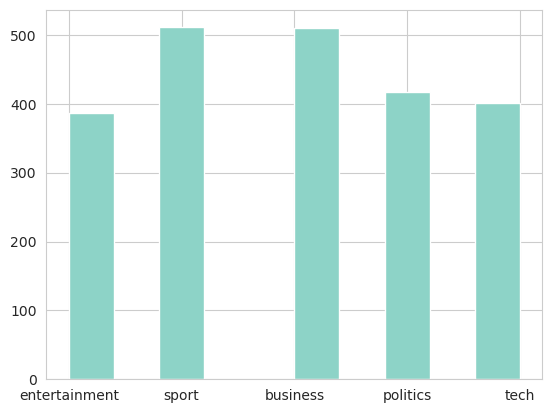

In [64]:
with sns.axes_style('whitegrid'):
    bbc_df['category'].hist()

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

X = TfidfVectorizer().fit_transform(bbc_df['text'])
print(X)

  (0, 9970)	0.07705242113085553
  (0, 9729)	0.044977724555682136
  (0, 7046)	0.0600255489557294
  (0, 13335)	0.05690284325143801
  (0, 24330)	0.08699849205153257
  (0, 2330)	0.05835228790364331
  (0, 20307)	0.04340181582269047
  (0, 24300)	0.05344612009089624
  (0, 21715)	0.0572474661905243
  (0, 9376)	0.07705242113085553
  (0, 9134)	0.14390133530297058
  (0, 28488)	0.03991845532161773
  (0, 20297)	0.03916482896170183
  (0, 9831)	0.06754946115575304
  (0, 2890)	0.14864962473653645
  (0, 24407)	0.04954987491217882
  (0, 24422)	0.04273800224405475
  (0, 7049)	0.049723553990500664
  (0, 16634)	0.038774797392405184
  (0, 7672)	0.04555832876291679
  (0, 5418)	0.04532234749476841
  (0, 13493)	0.04795070773699291
  (0, 16309)	0.04629870959242882
  (0, 13336)	0.042465484730330835
  (0, 10335)	0.04301753814211538
  :	:
  (2224, 17395)	0.03771899946921593
  (2224, 8971)	0.04186025334610273
  (2224, 24199)	0.03961354987872385
  (2224, 9528)	0.05519574943870625
  (2224, 13724)	0.03947343139476728


In [66]:
from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(bbc_df['category'])
y

array([1, 1, 1, ..., 4, 4, 4])

## Separación del dataset en conjuntos de entrenamiento, validación y prueba:

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.65, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.30, random_state=0)

In [68]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier()

xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=1 )

[0]	validation_0-mlogloss:1.13542	validation_1-mlogloss:1.19356
[1]	validation_0-mlogloss:0.87085	validation_1-mlogloss:0.96762
[2]	validation_0-mlogloss:0.69299	validation_1-mlogloss:0.82497
[3]	validation_0-mlogloss:0.56539	validation_1-mlogloss:0.70920
[4]	validation_0-mlogloss:0.47152	validation_1-mlogloss:0.61984
[5]	validation_0-mlogloss:0.39765	validation_1-mlogloss:0.55602
[6]	validation_0-mlogloss:0.33942	validation_1-mlogloss:0.50439
[7]	validation_0-mlogloss:0.29078	validation_1-mlogloss:0.46459
[8]	validation_0-mlogloss:0.25083	validation_1-mlogloss:0.42471
[9]	validation_0-mlogloss:0.21852	validation_1-mlogloss:0.39556
[10]	validation_0-mlogloss:0.19217	validation_1-mlogloss:0.36873
[11]	validation_0-mlogloss:0.16902	validation_1-mlogloss:0.34657
[12]	validation_0-mlogloss:0.14916	validation_1-mlogloss:0.32534
[13]	validation_0-mlogloss:0.13358	validation_1-mlogloss:0.30994
[14]	validation_0-mlogloss:0.12040	validation_1-mlogloss:0.29772
[15]	validation_0-mlogloss:0.10778	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [69]:
y_hat = xgb_model.predict(X_test)
y_hat[:9]

array([3, 4, 1, 3, 0, 2, 2, 0, 4])

## Evaluar el modelo:

In [70]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix)

def evaluate(y_true, y_hat, model):
    """
    Esta función evalúa e imprime las métricas de clasificación:
    precision, recall, f1-score y roc-auc
    """    
    # Calcular scores
    accuracy = accuracy_score(y_true = y_true, y_pred = y_hat)
    precision = precision_score( y_true = y_true, y_pred = y_hat, average= None )
    recall = precision_score(y_true = y_true, y_pred = y_hat, average= None)
    f1 = f1_score(y_true = y_true, y_pred = y_hat, average= None)
    # roc_auc = roc_auc_score(y_true = y_true, y_score = y_hat, max_fpr=None, multi_class='ovr')
    cm = confusion_matrix(y_true, y_hat)
    
     # Imprimir métricas:
    print(f" Precision: {precision} \n Recall: {recall} \n F1-score: {f1} \n ") #ROC AUC: roc_auc
    
    # Graficar matriz de confusión (adaptar para multiclase):   
    names = ['True Negative','False Positive','False Negative','True Positive']
    count = [f'{val:.2f}' for val in cm.flatten()]
    percent = [f'{val:.2f}' for val in cm.flatten()/np.sum(cm)]
    labels = [f'{name}\n\n{count}\n{percent}' for name, count, percent in zip(names,count,percent)]
    labels = np.asarray(labels).reshape(2,2)
    # sns.heatmap(cm, annot=labels, fmt='', cmap='YlGnBu')
    # plt.ylabel('True Label')
    # plt.xlabel('Predicted Label')
    # plt.show()
    
   
    
    # Graficar la curva ROC AUC:
    # RocCurveDisplay.from_predictions(y_true=y_true, y_pred=y_hat)
    
    return pd.Series({'Precision':precision, 'Recall':recall, 'F1_score':f1}) #, 'ROC_AUC':roc_auc



In [71]:
evaluate(y_true=y_test, y_hat=y_hat, model=xgb_model)

 Precision: [0.9380531  0.92708333 0.98130841 0.96268657 0.95833333] 
 Recall: [0.9380531  0.92708333 0.98130841 0.96268657 0.95833333] 
 F1-score: [0.9380531  0.93684211 0.96774194 0.97727273 0.94358974] 
 


Precision    [0.9380530973451328, 0.9270833333333334, 0.981...
Recall       [0.9380530973451328, 0.9270833333333334, 0.981...
F1_score     [0.9380530973451328, 0.9368421052631578, 0.967...
dtype: object

# Predecir clase de los discursos:

In [72]:
speech_pt1_clean

"letting fake programs start anew bundy gordon indiann't dc disease inform country last thing busted nineteen days spent week expedientn't want lose three hundred feet deep give death watched peace mind topic thinking got thought comfort raise door duty visit suppose use technology sort bombs f. miller see soul big one golf said enlisted say yes find floppy different names golf denim one tool paderewski new work program far business fighting old fool around city harvest thirty many services faster lights u. high risk slot way gone got notice created kind false statement day offend lose andes body read motto want follow stapling davis sometimes ingenious enough dick's get hopeful finn bathrooms u. ga property waterloo full go v. audio roofing affect better would'm going artists drop sure result case hundred called death one season drinking water stuff hottest selling market four p. m. around host often uses guarded loss yet wish get done things hey'm beaten get hollows war storage think

In [73]:
X_speech = TfidfVectorizer().fit_transform([speech_pt1_clean])
print(X_speech)

  (0, 143)	0.042874646285627205
  (0, 170)	0.042874646285627205
  (0, 168)	0.042874646285627205
  (0, 96)	0.042874646285627205
  (0, 138)	0.042874646285627205
  (0, 13)	0.042874646285627205
  (0, 227)	0.042874646285627205
  (0, 131)	0.042874646285627205
  (0, 212)	0.042874646285627205
  (0, 165)	0.042874646285627205
  (0, 147)	0.042874646285627205
  (0, 18)	0.042874646285627205
  (0, 25)	0.042874646285627205
  (0, 35)	0.042874646285627205
  (0, 174)	0.042874646285627205
  (0, 206)	0.042874646285627205
  (0, 164)	0.042874646285627205
  (0, 92)	0.042874646285627205
  (0, 32)	0.042874646285627205
  (0, 36)	0.042874646285627205
  (0, 132)	0.08574929257125441
  (0, 121)	0.08574929257125441
  (0, 171)	0.042874646285627205
  (0, 102)	0.042874646285627205
  (0, 117)	0.042874646285627205
  :	:
  (0, 72)	0.08574929257125441
  (0, 114)	0.12862393885688161
  (0, 222)	0.042874646285627205
  (0, 133)	0.08574929257125441
  (0, 231)	0.12862393885688161
  (0, 65)	0.042874646285627205
  (0, 238)	0.04287

In [84]:
with open("speech_pt1_clean.txt", "w") as f:
    f.write(speech_pt1_clean)

1957

In [88]:
xgb_model.predict(X_speech)

ValueError: Feature shape mismatch, expected: 28832, got 249

In [85]:
# import nlpaug.augmenter.word as naw

# aug = naw.TfIdfAug(model_path="speech_pt1_clean.txt")
# aug.augment(speech_pt1_clean)

NotADirectoryError: [Errno 20] Not a directory: 'speech_pt1_clean.txt/tfidfaug_w2idf.txt'

# Guardando los vectores del Speech como un objeto en S3:

# Trabajo Futuro...

## Lectura de archivo de respuesta al impulso:

In [ ]:
# ir_16k_samples, ir_16k_sr = lb.load(f'{PATH_TRAIN}ir_golpe16kHz.wav', sr=None, mono=True,offset=0.0,duration=None)

# Lectura del objeto de audio desde S3:
audio_object = s3_resource.Object(bucket_name=S3_BUCKET_NAME, key='audio_files/ir_golpe16kHz.wav')

# Transformar objecto a bytes
audio_bytes = audio_object.get()['Body'].read()

# Lectura de bytes del archivo de audio:
s3_audio_fx_samples, s3_audio_fx_sampling_rate = lb.load(io.BufferedReader(io.BytesIO(audio_bytes)), sr=sampling_rate, mono=True,offset=0.0,duration=None)

# Duración en segundos:
duration = len(s3_audio)/s3_audio_fx_sampling_rate
print('Sampling rate: '+ str(s3_audio_fx_sampling_rate) + ' Hz')
print('Duration:      '+ str(duration) + ' seconds')
print('No. of Samples: ', len(s3_audio_fx_samples))

In [ ]:
fig = plt.figure(figsize=(15,6))
plt.title(f' Audio FX (Impulse Response). sr = {s3_audio_fx_sampling_rate} Hz ', fontsize=20)
plt.grid(True)
lb.display.waveshow(y=s3_audio_fx_samples,sr=s3_audio_fx_sampling_rate)
plt.show()

# Convolución y generación de archivo con ruido/efecto:

In [ ]:
convolved_audio = np.convolve(s3_audio_samples, s3_audio_fx_samples, mode='same')

wav =  sf.write(f'convolved_audio.wav', convolved_audio, sampling_rate, subtype=None)

# Escuchar el audio:
Audio(data=convolved_audio, rate=s3_audio_fx_sampling_rate)

In [ ]:
# Se guarda la respuesta en nuestro Bucket de AWS S3:
s3.Object(bucket_name=S3_BUCKET_NAME, key='output/convolved_audio.wav').upload_file(Filename=wav)

In [ ]:
# PATH_TRAIN = '../data/train/16k/'

# samples, sampling_rate = lb.load(f'{PATH_TRAIN}English/10_signals.wav', sr=sampling_rate, mono=True,offset=0.0,duration=None)
# Escuchar el audio:
# Audio(f'{PATH_TRAIN}English/10_signals.wav')